In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import KFold

from recommender import matrix_factorization, find_best

np.random.seed(seed=1983)

In [2]:
## Dummy dataset
a = pd.DataFrame([

     [1,5,3,0,1],

     [2,4,0,0,1],

     [3,1,1,0,5],

     [4,1,0,0,4],

     [5,0,1,5,4],
    
     [6,2,1,3,0],

    ]).set_index(0)

a.index.names = ['userId']
a.columns.names = ['movieId']

In [3]:
mse = find_best(a)

K: 10	 | Learning_rate: 0.001	 | MSE:86.19764374597133
K: 10	 | Learning_rate: 0.01	 | MSE:75.27549809887026
K: 10	 | Learning_rate: 0.1	 | MSE:44.69767556503066
K: 10	 | Learning_rate: 1	 | MSE:11.147331713687645
K: 20	 | Learning_rate: 0.001	 | MSE:245.3282233064986
K: 20	 | Learning_rate: 0.01	 | MSE:117.54347596705956
K: 20	 | Learning_rate: 0.1	 | MSE:36.635692361750955
K: 20	 | Learning_rate: 1	 | MSE:9.154583450659855
K: 30	 | Learning_rate: 0.001	 | MSE:578.8796576099611
K: 30	 | Learning_rate: 0.01	 | MSE:150.230904724879
K: 30	 | Learning_rate: 0.1	 | MSE:40.60265488225037
K: 30	 | Learning_rate: 1	 | MSE:7.06576706595043
K: 40	 | Learning_rate: 0.001	 | MSE:1030.7235031481853
K: 40	 | Learning_rate: 0.01	 | MSE:192.13264930242894
K: 40	 | Learning_rate: 0.1	 | MSE:40.2223866165279
K: 40	 | Learning_rate: 1	 | MSE:7.312019018531259
K: 50	 | Learning_rate: 0.001	 | MSE:1372.1325244469099
K: 50	 | Learning_rate: 0.01	 | MSE:234.69464498422556
K: 50	 | Learning_rate: 0.1	 | MSE:

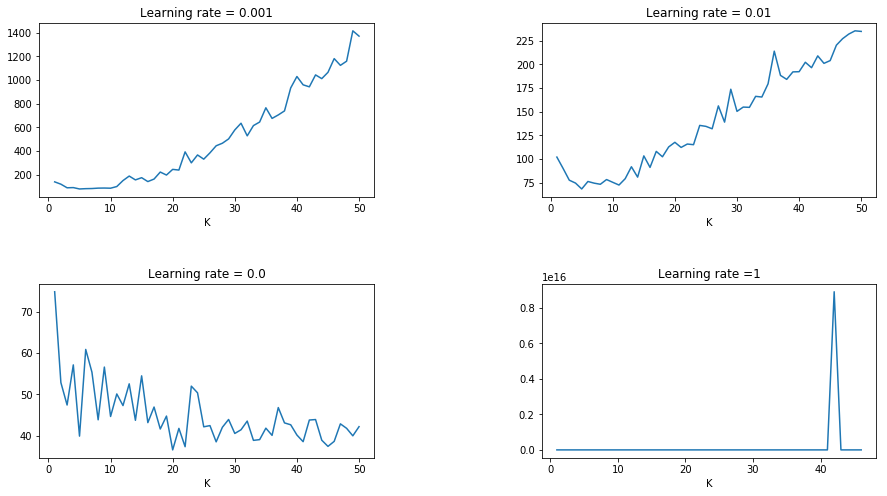

In [127]:
## Get minimum by Learning rate

## plot best k with bets learning rate
fig, axes = plt.subplots(2, 2, figsize=(15, 8))
plt.subplots_adjust(wspace=0.5, hspace=0.5)

mse[mse['Learning_rate']==0.001].plot(x="K", y="MSE", ax=axes[0,0], legend=False)
axes[0, 0].set_title('Learning rate = 0.001')
mse[mse['Learning_rate']==0.01].plot(x="K", y="MSE", ax=axes[0,1], legend=False)
axes[0, 1].set_title('Learning rate = 0.01')
mse[mse['Learning_rate']==0.1].plot(x="K", y="MSE", ax=axes[1,0], legend=False)
axes[1, 0].set_title('Learning rate = 0.0')
mse[mse['Learning_rate']==1].plot(x="K", y="MSE", ax=axes[1,1], legend=False,)
axes[1, 1].set_title('Learning rate =1')
plt.show()

In [4]:
mse.loc[mse.MSE.idxmin()]

K                46.00000
Learning_rate     1.00000
MSE               6.69193
Name: 183, dtype: float64

In [162]:
## Best matrix with best k
recomm = matrix_factorization(a,46)
## Train the model, default iterations is 2
recomm.fit(1,20)

In [163]:
## Increasing iterations improves over previous best MSE
min(recomm.mse)

6.00113445620528

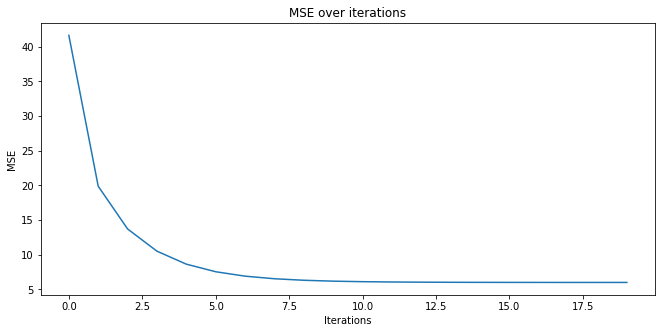

In [164]:
## Plot MSE over iterations
plt.figure(figsize=(11, 5))
plt.plot(recomm.mse)
plt.xlabel('Iterations')
plt.ylabel('MSE')
plt.title('MSE over iterations')
plt.show()

In [165]:
## Get the Predicted matrix
recomm.matrix

array([[5.48739966, 3.49889043, 0.50508037, 1.50379903],
       [4.48190465, 0.51182098, 0.50193242, 1.50273406],
       [1.50452784, 1.49635492, 0.49979124, 5.49945531],
       [1.50948973, 0.49814052, 0.49725141, 4.49768566],
       [0.51600362, 1.49416413, 5.49644428, 4.49664488],
       [2.50067451, 1.50062902, 3.49950029, 0.49968106]])

In [166]:
## Top n recommends by user
recomm.top_recommends(1)

,movieId,rating,title
0,2,3.0,Ariel
1,3,1.0,Shadows in Paradise


## EDA

In [167]:
ratings = pd.read_csv("data/ratings_small.csv")

In [168]:
##Columns not needed
ratings.drop('timestamp', axis=1, inplace=True)

In [169]:
## Order by movieId
ratings.sort_values('movieId', inplace=True)

In [170]:
## Remove float ratings by casting to int
ratings['rating'] = ratings['rating'].astype(int)

In [171]:
ratings.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100004 entries, 9713 to 80823
Data columns (total 3 columns):
 #   Column   Non-Null Count   Dtype
---  ------   --------------   -----
 0   userId   100004 non-null  int64
 1   movieId  100004 non-null  int64
 2   rating   100004 non-null  int32
dtypes: int32(1), int64(2)
memory usage: 2.7 MB


In [172]:
ratings.head()

,userId,movieId,rating
9713,68,1,4
35933,261,1,1
52631,383,1,5
35983,262,1,2
12038,77,1,4


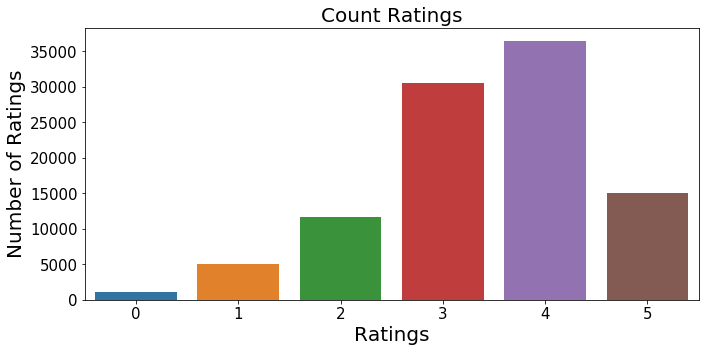

In [173]:
plt.figure(figsize = (11, 5))
sns.countplot(x="rating", data=ratings)
plt.tick_params(labelsize = 15)
plt.title("Count Ratings", fontsize = 20)
plt.xlabel("Ratings", fontsize = 20)
plt.ylabel("Number of Ratings", fontsize = 20)
plt.show()

In [174]:
## Group by userid and count the numbers of movies rated by that user
ratings.groupby("userId")["rating"].count().sort_values(ascending = False).head()

userId
547    2391
564    1868
624    1735
15     1700
73     1610
Name: rating, dtype: int64

In [175]:
## Group by movies and count the number of users rated that movie
ratings.groupby("movieId")["rating"].count().sort_values(ascending = False).head()

movieId
356    341
296    324
318    311
593    304
260    291
Name: rating, dtype: int64

In [176]:
## set userId as index
ratings = ratings.set_index('userId').sort_index(axis = 0)

In [177]:
ratings

,movieId,rating
userId,,
1,2455,2
1,1287,2
1,2968,1
1,1339,3
1,1172,4
...,...,...
671,1266,4
671,1197,3
671,4022,3


In [178]:
## pivot df to get the matrix Yai
ratings = ratings.pivot(index=ratings.index, columns='movieId')['rating']

In [179]:
## replace NAN with movie mean
ratings = ratings.fillna(ratings.mean())
## replace NAN with zero
#ratings = ratings.fillna(0)

In [180]:
ratings

movieId,1,2,3,4,5,6,7,8,9,10,...,161084,161155,161594,161830,161918,161944,162376,162542,162672,163949
userId,,,,,,,,,,,,,,,,,,,,,
1,3.773279,3.317757,3.084746,2.307692,3.178571,3.817308,3.226415,3.8,3.15,3.344262,...,2.0,0.0,3.0,1.0,1.0,5.0,4.0,5.0,3.0,5.0
2,3.773279,3.317757,3.084746,2.307692,3.178571,3.817308,3.226415,3.8,3.15,4.000000,...,2.0,0.0,3.0,1.0,1.0,5.0,4.0,5.0,3.0,5.0
3,3.773279,3.317757,3.084746,2.307692,3.178571,3.817308,3.226415,3.8,3.15,3.344262,...,2.0,0.0,3.0,1.0,1.0,5.0,4.0,5.0,3.0,5.0
4,3.773279,3.317757,3.084746,2.307692,3.178571,3.817308,3.226415,3.8,3.15,4.000000,...,2.0,0.0,3.0,1.0,1.0,5.0,4.0,5.0,3.0,5.0
5,3.773279,3.317757,4.000000,2.307692,3.178571,3.817308,3.226415,3.8,3.15,3.344262,...,2.0,0.0,3.0,1.0,1.0,5.0,4.0,5.0,3.0,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
667,3.773279,3.317757,3.084746,2.307692,3.178571,4.000000,3.226415,3.8,3.15,3.344262,...,2.0,0.0,3.0,1.0,1.0,5.0,4.0,5.0,3.0,5.0
668,3.773279,3.317757,3.084746,2.307692,3.178571,3.817308,3.226415,3.8,3.15,3.344262,...,2.0,0.0,3.0,1.0,1.0,5.0,4.0,5.0,3.0,5.0
669,3.773279,3.317757,3.084746,2.307692,3.178571,3.817308,3.226415,3.8,3.15,3.344262,...,2.0,0.0,3.0,1.0,1.0,5.0,4.0,5.0,3.0,5.0


In [ ]:
## Best matrix with best k
rec = matrix_factorization(ratings,46)
## Train the model
rec.fit(1)

In [ ]:
## Get the Predicted matrix
rec.matrix

In [ ]:
## Top n recommends by user. default is 5
recomm.top_recommends(1)